In [34]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.corpora import Dictionary
from gensim.matutils import kullback_leibler
from gensim.models import LdaModel

## An (attempt at an) Introduction to Computational Social Science with Python

- by Bhargav Srinivasa Desikan

This tutorial was first conducted at PyCon India 2020 ([CFP](https://in.pycon.org/cfp/2020/proposals/python-for-computational-social-science-with-text-networks-and-clever-data-games~dyPPE/)).

Computational Social Science is a broad, diverse field, and no tutorial, let alone Jupyter notebook, can claim to give a true introduction to the field: what we will attempt to do in this notebook is understand the _kinds_ of approaches one might be able to take when dealing with a variety of computational social science questions.

What is Computational Social Science? It includes the academic sub-disciplines concerned with computational approaches (such as data scraping, data cleaning, machine learning, natural language processing and others) to various social science disciplines. Social science disciplines include Economics, Sociology, Psychology, Political Science, Anthropology, Cultural Studies (and sometimes History & Science-Technology-Society Studies). Examples of computational approaches to social science questions could be characterising tie forming in friendship groups, analysing tweets to identify sentiment towards political groups, modelling economies and their reactions to changes in policy, or identifying how words in a language change meaning over time.

While the idea of computational social science is based in academia and research, we see usages of these ideas by big tech companies all the time: for example, when we see a friend or page suggestion on a social media website, or a movie recommendation on Netflix. In research, academic and experimental rigor is valued more than a business oriented approach, but the core ideas often remain the same.

The computational paradigm has taken off due to a congruence of hardware (GPUs, TPUs), software (larger communities of open source software, increasingly sophisticated sophisticated software and environments), and large amounts of available social data. Social data can range from curated datasets we can find on kaggle or the UCI repository, or data we mine from reddit or twitter. Important aspects of Computational Social Science include choosing a right research question, studying the theoretical underpinnings associated with the questions, and setting up an experiment or mining data which might be able to appropriately address the question. Given that this is a tough expercise, and requires extensive academic coursework, I will be skipping the academic rigor, to instead explore the kinds of approaches and methods one might encounter in Computational Social Science research.

How will this tutorial be useful to you? It will include basic examples of code with small datasets to illustrate a variety of methods often used in CSS research. This includes (and is not limited to) text analysis via Natural Language Processing and Computational Linguistics, network and graph oriented methods, and building classifiers and regression models trained on a variety of social data.

Since it is difficult to represent all of these methods, I will only focus on a few, with a focus on NLP and CL, as these are the methods I have most experience in. We will then move on to network based methods, and finally move on to a combination of both text and networks. The tutorial will assume basic python knowledge but not much else: do not worry if some of the methods or ideas don't make sense yet. A lot of the words and ideas I have used in this tutorial have ample resources available if you wish to understand them, and you are also welcome to e-mail / tweet at me any questions you have and I will do my best to answer them. If you find yourself reproducing parts of this tutorial for your own work or tutorials, please do cite / shout-out / reference this original tutorial and page, thank you!

### Where do you find data? What is the correct dataset?

This is an always challenging question. Really, it depends on the question you want to answer: there are a lot of considerations one must take when deciding if a dataset is the right one to answer your social science question. Since this tutorial would like to introduce a wide variety of methods, the dataset we choose has to be one which is ammenable to a variety of approaches: to that end, I have decided to use the script for the Indo-British film, _Bend it like Beckham_. Why this film? It's simply the last movie I watched, I enjoyed it watching it as a kid back in the early 2000s, and the movie also kicks _ass_. For those who may not have seen it, it was the story of how an Indian-British Punjabi girl, Jesminder (Jess) and her coming of age story of becoming a professional footballer. I have to apologize - SPOILERS! During the various methods we will be applying throughout the notebook, you might learn things about the movie you might have wanted to keep a surprise if you haven't seen it.

I found the script of the movie through a simple google search, at https://www.swcs.com.au/bend.htm. Like you so far, I have no clue what to expect of the results of the analysis - we are going to try and use the data in its avaible form to create objects of analysis for us. Let is start by setting up some basic imports and reading the data, and thinking of useful representations.

### Imports and Data

Arguably the most important part of Computational Social Science is cleaning and organising the data. The following cells will have you follow me as I work to set up the best representations to analyse the dataset.

In [35]:
txt_file = open("./bend_it_like_beckham.txt")
txt = []
for line in txt_file.readlines():
    txt.append(line)

In [36]:
txt

["John: David Beckham gets the ball yet again for Manchester United. He's really taking responsibility every time they have possession. This is really a reflection of the way he's been playing and captaining England. He seems to have matured so much as a player He's dominating proceedings here but, hoping perhaps to get a bit more support as he gathers the ball on this right-hand touchline time after time. And the Old Trafford crowd warming now to the way Beckham is taking over, but the big questionmark here against Manchester United is, where is the goal going to come from to break down Anderlecht? Will it be Scholes? Could it possibly be Ryan Giggs? Would it possibly be Beckham himself who breaks through? Because Anderlecht are playing a very controlled game. This is Radzinski, testing the United defence, and Sylvestre here at left back possibly with a chance to break forward on the other flank. And there's the ball that Beckham really wants. Oh that looked like a body check there, b

There: we now have each line from the movie (as well as it has been transcribed, at least: we do not know anything about the quality of the document) saved in a list.

In [37]:
len(txt)

1619

In [38]:
txt[0]

"John: David Beckham gets the ball yet again for Manchester United. He's really taking responsibility every time they have possession. This is really a reflection of the way he's been playing and captaining England. He seems to have matured so much as a player He's dominating proceedings here but, hoping perhaps to get a bit more support as he gathers the ball on this right-hand touchline time after time. And the Old Trafford crowd warming now to the way Beckham is taking over, but the big questionmark here against Manchester United is, where is the goal going to come from to break down Anderlecht? Will it be Scholes? Could it possibly be Ryan Giggs? Would it possibly be Beckham himself who breaks through? Because Anderlecht are playing a very controlled game. This is Radzinski, testing the United defence, and Sylvestre here at left back possibly with a chance to break forward on the other flank. And there's the ball that Beckham really wants. Oh that looked like a body check there, bu

In [39]:
txt[23]

"Pinky: Can you hurry up. I'm telling you Mum, that girl is a first-class b****!\n"

In [40]:
txt[25]

"Jess's Mother: - Pinky, you've got so many others!\n"

Ok, so looking at these output examples starts to give us some hints. The first word of each text is usually the character's name, followed by a colon, and then the text. This gives us some ideas on how to parse this dataset. Let us probe what else is there in this dataset. Sentences without a colon might be associated with a song and commentary, so for now we will add it in our extras list.

In [41]:
extras, texts = [], []
character_counts = {}
for line in txt:
    try:
        character, text = line.split(":")
    except ValueError:
        if line != "\n":
            extras.append(line)
        continue

    if character in character_counts:
        character_counts[character] += 1

    if character not in character_counts:
        character_counts[character] = 1

    if text != "\n":
        texts.append(text)
extras

["Uh-oh, there's your mate. Let's make this quick yeah and I hope your mate's mum wears a cardi over her three stomachs tomorrow!\n",
 'Rubbish! Come on, boys!\n',
 "You're such an idiot, man!\n",
 'Beckham or what?\n',
 'Can we chest it like him?\n',
 '- You know, give it some bounce!\n',
 '- Go on! Chest it!\n',
 '- Did that hurt, pretty boy?\n',
 "- I'll get one for your wedding, too, if you like.\n",
 '- Innit, innit? I know!\n',
 "He's taking his shirt off!\n",
 'A body like that should come with an X certificate warning!\n',
 'And a lifetime guarantee!\n',
 '- Yeah, man! Call Jess!\n',
 '- Oy, Jess!\n',
 "- Jess man, who's your friend with the gorgeous bod?\n",
 '- The one with the six-pack.\n',
 '- If he looks at me, I really will faint!\n',
 '- Look at that kick!\n',
 'He is so fly!\n',
 'That is fine. That is so fine!\n',
 "Hey. Who's that gori watching her?\n",
 'Southall United Sari Squad?\n',
 'And get in a big bath together?\n',
 "Where's the soap?\n",
 "Yeah, it does, doe

A quick look at the list confirms our hypothesis. Lets now see what characters we find:

In [42]:
character_counts

{'John': 2,
 'Gary': 3,
 'Alan': 1,
 "Jess's Mother": 5,
 "Jess's Mother at the door": 1,
 'Jess': 191,
 'Pinky': 37,
 'Jess & Pinkie': 1,
 "At Shop - Pinkie's friend": 1,
 'Pinkie': 10,
 "Pinkie's friend": 1,
 "Pinkie's friends": 1,
 'In another shop Jules': 1,
 "Jules's' Mum": 1,
 'Jules': 89,
 "Jules's Mum": 29,
 'Walking - Pinkie': 1,
 'Tony': 35,
 'Pinkie and Jess': 2,
 "Tony's Mum": 2,
 'After they leave - Tony': 1,
 'Pinkie - walking': 1,
 'Later at the Park - Soccer fellows': 1,
 'Soccer fellows': 1,
 'Back home in bedroom - Jess': 1,
 "Jess's Dad": 38,
 'Dad': 1,
 'Man at engagement party': 1,
 'Lady at engagement party': 1,
 'Mobile phones ring - Teet answers his': 1,
 'Later at Soccer field - Girls watching boys': 1,
 'Girls': 2,
 'Soccer Boy to Tony': 1,
 'Girl 1': 1,
 'Girl 2': 1,
 'After game - Jules': 1,
 'Soccer Boys': 2,
 'Later - Soccer Girl': 1,
 'Coach': 80,
 'Later on bed Jess': 1,
 "Outside at Jules's house - Jules kicks ball in to pots": 1,
 "Jules's Dad": 17,
 "

In [43]:
character_counts["Song Playing"]

15

This is an important list: it tells us how many lines each of the chatacters had, at least the way it was transcribed. Can we somehow use this information to find key characters, and to also find transitions in scenes?

A little bonus: we that 15 songs have been played in the movie!

In [44]:
locations_transitions = []
key_characters = []
for character in character_counts:
    if character_counts[character] > 25:
        key_characters.append(character)
    location_transition_keywords = [
        "at ",
        "then",
        "later",
        "in ",
        "outside",
        "back",
        "inside",
        "on ",
        "after",
        "walking",
        "next",
    ]
    for word in location_transition_keywords:
        if (
            word in character.lower()
            and character.lower() != "tony"
            and character.lower() != "pinky"
        ):
            locations_transitions.append(character)
            continue

locations_transitions

["Jess's Mother at the door",
 "At Shop - Pinkie's friend",
 'In another shop Jules',
 'Walking - Pinkie',
 'After they leave - Tony',
 'Pinkie - walking',
 'Later at the Park - Soccer fellows',
 'Later at the Park - Soccer fellows',
 'Back home in bedroom - Jess',
 'Back home in bedroom - Jess',
 'Man at engagement party',
 'Lady at engagement party',
 'Later at Soccer field - Girls watching boys',
 'Later at Soccer field - Girls watching boys',
 'After game - Jules',
 'Later - Soccer Girl',
 'Later on bed Jess',
 'Later on bed Jess',
 "Outside at Jules's house - Jules kicks ball in to pots",
 "Outside at Jules's house - Jules kicks ball in to pots",
 "Outside at Jules's house - Jules kicks ball in to pots",
 'Later at the field Coach',
 'Later at the field Coach',
 'Walking away Coach',
 'In Change room Jules',
 'Outside Coach',
 'Later Jess',
 "Later at home Jess's Mum",
 "Later at home Jess's Mum",
 "Next day Jess's Mum",
 'At Home Jess',
 'Later at Soccer Training Jules',
 'Later 

These aren't perfect, and we might have missed some of them, but they will be very useful in creating co-occurence counts: i.e, two characters share screen time.

NOTE: use regex to match the locations and transitions!

In [45]:
key_characters

['Jess',
 'Pinky',
 'Jules',
 "Jules's Mum",
 'Tony',
 "Jess's Dad",
 'Coach',
 "Jess's Mum"]

That makes sense, having seen the movie. Now let us make some datasets for us which will be useful for analysis!

In [46]:
key_character_texts = {}
for line in txt:
    try:
        character, text = line.split(":")
    except ValueError:
        continue
    if character in key_characters:
        if character not in key_character_texts:
            key_character_texts[character] = []
        if character in key_character_texts:
            key_character_texts[character].append(text.replace("\n", ""))

In [47]:
for character in key_character_texts:
    print(character, len(key_character_texts[character]))

Jess 191
Pinky 37
Jules 89
Jules's Mum 29
Tony 35
Jess's Dad 38
Coach 80
Jess's Mum 52


In [48]:
key_character_texts["Jess"]

[" Mum, it's Beckham's corner!",
 " I'm sick of this wedding and it hasn't even started!",
 " - What the hell's going on?",
 ' Mum, do I have to go shopping again?',
 " - Shut up! She's old.",
 ' - Did you do the genetics one?',
 " - Yeah I got that, too. - I Hope I get my 2 A's and a B for uni.",
 " - Yeah I'll try.",
 " - I can't. My mum's waiting, - my dad's on earlies at Heathrow.",
 ' No one, Dad.',
 ' - Dad!',
 ' - What? Taz?',
 " Oh shut up. You know he's just my mate. We're not all slags like you lot!",
 " - A trial? Think I'm good enough?",
 ' - Jess.',
 ' - Hi.',
 ' - In the park.',
 ' Sorry! I usually play all over, but up front on the right is best.',
 " - I haven't got any.",
 ' - Where shall I put this?',
 ' - Really great!',
 " - I didn't even know they had a girls' team here.",
 " - Yeah, they're cool.",
 ' - You think so?',
 ' - For ages, but just in the park. - Nothing as serious as this.',
 ' - Wow! Can you do that? I mean, as a job, like.',
 ' Really?',
 ' Thanks',


In [49]:
len(texts)

776

Neat: we now have each character and their associated texts, and the individual texts, so we can create our first network based object, based on interactions.

## Graphs and Networks

Graphs and networks can be a very useful way to represent data, and can provide us all kinds of insights.

I would highly, highly recommend checking out this amazing set of Jupyter Notebooks and resources by Mridul Seth and Eric Ma: http://ericmjl.github.io/Network-Analysis-Made-Simple/

I will not be going into a real introduction to the theories and ideas behind graphs and networks, but I will explain how they are useful for us in social scientific analysis. A graph can be thought of as a representation of data in a way you can measure connections or relations, and the kind of relations.

Examples (taken from Network Analysis Made Simple) of graphs are:

1) protein-protein interaction network. Here, the graph can be defined in the following way:

    nodes/entities are the proteins,
    edges/relationships are defined as "one protein is known to bind with another".

2) air transportation network. Here, the graph can be defined in the following way:

    nodes/entities are airports
    edges/relationships are defined as "at least one flight carrier flies between the airports".

3) social networks: With Twitter, the graph can be defined in the following way:

    nodes/entities are individual users
    edges/relationships are defined as "one user has decided to follow another".

How can we extend these examples to our data set?
It would be useful to know which characters are in the same scences, so we can measure which characters are most central, and so on.

In [50]:
character_graph = nx.Graph()
for character in key_characters:
    character_graph.add_node(character)

In [51]:
scenes = {}
idx = 0
scenes[idx] = []
for line in txt:
    try:
        character, text = line.split(":")
    except ValueError:
        continue
    if character in key_characters and character not in scenes[idx]:
        scenes[idx].append(character)
    if character in locations_transitions:
        idx += 1
        scenes[idx] = []

KeyError: 74

In [52]:
scenes

{0: [], 1: []}

We now have information about which characters share a scence, and can build our graph.

In [53]:
for scene in scenes:
    if len(scenes[scene]) > 1:
        for character_0 in scenes[scene]:
            for character_1 in scenes[scene]:
                if character_0 != character_1:
                    if (
                        character_0,
                        character_1,
                    ) not in character_graph.edges():
                        character_graph.add_edge(character_0, character_1, weight=0)
                    if (character_0, character_1) in character_graph.edges():
                        character_graph.edges[(character_0, character_1)]["weight"] += 1

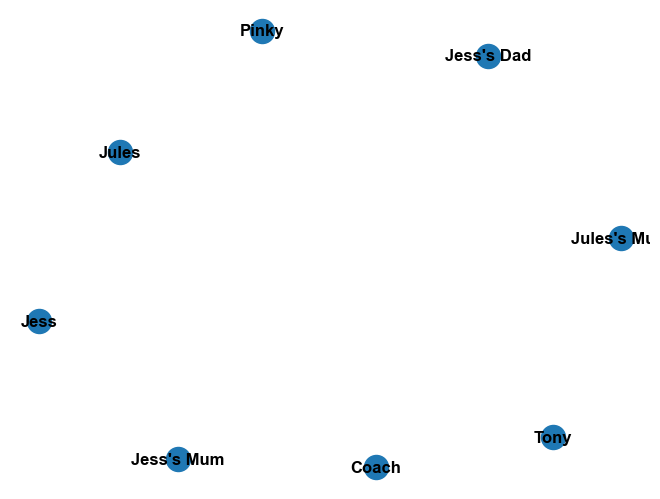

In [54]:
nx.draw(character_graph, with_labels=True, font_weight="bold")

In [30]:
character_graph.edges()[("Jess", "Pinky")]

{'weight': 24}

We can see how this graph gives us a lot of information: we see which characters appear in the same scence together, and can get an idea of centrality, as well as the numnber of times two characters share a scence.

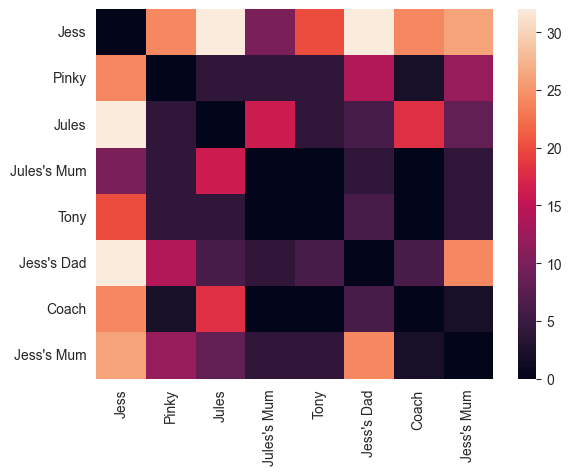

In [31]:
super_l = []
for node in character_graph.nodes():
    sub_l = []
    for node_ in character_graph.nodes():
        if node == node_:
            sub_l.append(0)
        else:
            if (node, node_) in character_graph.edges():
                sub_l.append(character_graph.edges[(node, node_)]["weight"])
            else:
                sub_l.append(0)
    super_l.append(sub_l)
M_ = np.array(super_l)
fig = plt.figure()
div = pd.DataFrame(
    M_,
    columns=list(character_graph.nodes()),
    index=list(character_graph.nodes()),
)
ax = sns.heatmap(div)
plt.show()

We can use our co-occurence graph to plot which characters share the screen with each other. Let's also use this graph to find the most central characters.

In [32]:
nx.algorithms.centrality.degree_centrality(character_graph)

{'Jess': 1.0,
 'Pinky': 1.0,
 'Jules': 1.0,
 "Jules's Mum": 0.7142857142857142,
 'Tony': 0.7142857142857142,
 "Jess's Dad": 1.0,
 'Coach': 0.7142857142857142,
 "Jess's Mum": 1.0}

Let's do some catch up: we have created a graph which maps how often characters share the screen together. This allows us to visualise how often characters appear with each other, and calculate centralities, where we see that Jess, Jules and Jess's Dad share the screen with every other character. This makes sense because they are three central characters.

But with every character more or less linked to every other one, it's tough to see any cliques or groups. What if we make the threshold higher?

In [33]:
stricter_graph = nx.Graph()
for character_0 in character_graph.nodes():
    stricter_graph.add_node(character_0)
    for character_1 in character_graph.nodes():
        if (
            character_0 != character_1
            and (character_0, character_1) in character_graph.edges()
        ):
            if character_graph.edges()[(character_0, character_1)]["weight"] > 20:
                stricter_graph.add_edge(character_0, character_1)

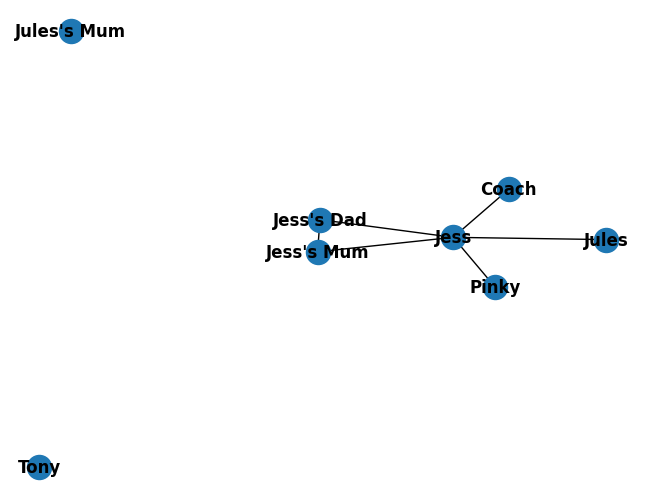

In [43]:
nx.draw(stricter_graph, with_labels=True, font_weight="bold")

This graph gives us an idea of the cliques: Jess is clearly the main character, and Jules's Mum speaks to everyone else the least. So far the networks have been useful in identifying the key players and relationships! We can also Jess's Mom and Dad forming a clique with Jess.

Let's take a break from networks and move on to analysing some of the actual text spoken in the movie.

## Text Analysis

Text is used as information in all kinds of situations, and is used heavily in social scientific analysis. There are a very wide variety of text related methods one can use for different purposes. Text analysis can be useful for classifying documents and lines, for identifying intent, semantic content, parts of speech, named entities, and many more purposes. It can even be used to generate text, such as in chatbots. For a tutorial focusing only on text analysis, please see: https://github.com/bhargavvader/personal/blob/master/notebooks/text_analysis_tutorial/text_analysis_tutorial.ipynb

We will be using one of the methods used in that notebook: Topic Modelling. Topic modelling is an unsupervised statistical learning algorithm which can be used to identify topics in large bodies of text. For example, if we were running topic models on newspapers, we'd likely see topics associated to the weather, politics, and sports. The algorithm assumes that topics are made of words, and documents are made of words. Similarly, documents can also be thought of as made up of topics. All of this will be more clear once we see the actual topics generated.

For a tutorial specifically for topic modelling, please see:
https://github.com/bhargavvader/personal/blob/master/notebooks/text_analysis_tutorial/topic_modelling.ipynb

In [45]:
nlp = spacy.load("en_core_web_sm")

In [46]:
my_stop_words = ["yeah", "like", "look"]
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [47]:
# we add some words to the stop word list
cleaned_texts, article = [], []
for line in texts:
    doc = nlp(line.lower())
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if (
            w.text != "\n"
            and not w.is_stop
            and not w.is_punct
            and not w.like_num
            and w.text != "I"
            and w.text.strip() != ""
        ):
            # we add the lematized version of the word
            article.append(w.lemma_)
    cleaned_texts.append(article)
    article = []

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-47-86ad87889221>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text != 'I' and w.text.strip() is not '':


In [48]:
cleaned_texts[9]

['come', 'downstairs', 'sister', 'go', 'crazy']

In [49]:
dictionary = Dictionary(cleaned_texts)
corpus = [dictionary.doc2bow(text) for text in cleaned_texts]

In [50]:
corpus[9]

[(12, 1), (31, 1), (137, 1), (143, 1), (144, 1)]

In [51]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [52]:
ldamodel.print_topics()

[(0,
  '0.026*"know" + 0.020*"come" + 0.020*"want" + 0.016*"oh" + 0.015*"joe" + 0.013*"jule" + 0.013*"go" + 0.012*"good" + 0.011*"play" + 0.011*"get"'),
 (1,
  '0.027*"jess" + 0.022*"hot" + 0.015*"get" + 0.014*"good" + 0.013*"think" + 0.012*"mum" + 0.009*"dream" + 0.009*"go" + 0.009*"tell" + 0.008*"sorry"'),
 (2,
  '0.031*"mum" + 0.024*"jess" + 0.022*"dad" + 0.018*"go" + 0.015*"know" + 0.014*"play" + 0.012*"good" + 0.011*"oh" + 0.011*"come" + 0.011*"thank"'),
 (3,
  '0.022*"come" + 0.020*"want" + 0.017*"play" + 0.013*"need" + 0.012*"football" + 0.012*"girl" + 0.010*"team" + 0.009*"boy" + 0.009*"ball" + 0.008*"mum"'),
 (4,
  '0.019*"want" + 0.016*"come" + 0.013*"hot" + 0.011*"play" + 0.010*"let" + 0.010*"go" + 0.010*"know" + 0.010*"get" + 0.010*"oh" + 0.008*"right"')]

We can see here 5 topics: one is to do with talking to Mums (there is a lot of that going on in this movie), abuot playing, one about Jess, and one to do with the coach. We can try and guess which kinds of scenes are dominated by which topics (or write some code to identify it, too!).

So we now see the power of topic models in getting a birds eye view of a large body of text: it can be even more powerful on larger texts with more well defined topics. I highly encourage you to check out both the tutorials I linked to earlier, they cover the same methods but in more detail. This is also just the beginning of the power of such methods: gensim has a variety of tutorials in their documentation on different ways you can use such models.

## Networks + Topics

We're now going to combine both of the ideas we explored! We can use these topic models to get an idea of the kinds of things each of the key characters talked about. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals in the French revolution.

Let us use some of these ideas to create a graph which also contains information of the topic distributions of each of the key characters.

In [53]:
key_character_texts_cleaned = {}
key_character_all_words = {}
key_character_doc2bow = {}

In [86]:
for character in key_character_texts:
    key_character_texts_cleaned[character] = []
    for line in key_character_texts[character]:
        doc = nlp(line.lower())
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article!
            if (
                w.text != "\n"
                and not w.is_stop
                and not w.is_punct
                and not w.like_num
                and w.text != "I"
                and w.text.strip() != ""
            ):
                # we add the lematized version of the word
                article.append(w.lemma_)
            # if it's a new line, it means we're onto our next document
        key_character_texts_cleaned[character].append(article)
        article = []
    # now that we have all the cleaned texts, we can find all the words used
    key_character_all_words[character] = []
    for line in key_character_texts_cleaned[character]:
        for word in line:
            key_character_all_words[character].append(word)
    # we convert these words to doc2bow
    key_character_doc2bow[character] = dictionary.doc2bow(
        key_character_all_words[character]
    )
    # we convert the doc2bow to topic proportions, and assign to the graph
    character_graph.nodes()[character]["topic_proportions"] = ldamodel[
        key_character_doc2bow[character]
    ]

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-86-6900668f811b>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text != 'I' and w.text.strip() is not '':


In [ ]:
# to make all the lists equal size
# character_graph.nodes['Jules']['topic_proportions'].append((4,0.04))

In [87]:
for actor in character_graph.nodes():
    print(actor, character_graph.nodes[actor]["topic_proportions"])

Jess [(0, 0.3209911), (1, 0.07143412), (2, 0.34901363), (3, 0.1515386), (4, 0.10702256)]
Pinky [(0, 0.1633667), (1, 0.16749978), (2, 0.38361058), (3, 0.12026661), (4, 0.16525632)]
Jules [(0, 0.29452112), (1, 0.18516092), (2, 0.39762777), (3, 0.061691035), (4, 0.060999174)]
Jules's Mum [(0, 0.637492), (1, 0.1598461), (2, 0.03119343), (4, 0.17056012)]
Tony [(0, 0.21989244), (1, 0.24369383), (2, 0.3661856), (4, 0.16855803)]
Jess's Dad [(0, 0.33685791), (1, 0.111645155), (2, 0.17211139), (3, 0.13577412), (4, 0.24361141)]
Coach [(0, 0.18615283), (1, 0.14943211), (2, 0.3329072), (3, 0.13644166), (4, 0.19506617)]
Jess's Mum [(0, 0.22637466), (1, 0.18486808), (2, 0.14112559), (3, 0.20794602), (4, 0.23968562)]


We now have our graph with the topic proportions as well! Let us now see how similar or different they are to each other. We can measure topic similarity or difference using certain information metrics which measure probability similarities.

In [88]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [89]:
super_l = []
for actor_1 in character_graph.nodes():
    p = character_graph.nodes[actor_1]["topic_proportions"]
    p = convert_to_prob(p)
    sub_l = []
    for actor_2 in character_graph.nodes():
        q = character_graph.nodes[actor_2]["topic_proportions"]
        q = convert_to_prob(q)
        sub_l.append(kullback_leibler(p, q))
    super_l.append(sub_l)
M = np.array(super_l)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (4,).

In [90]:
index = [x[0] for x in character_graph.nodes[actor_2]["topic_proportions"]]
omit = set(range(0, 5)) - set(index)

q = character_graph.nodes[actor_2]["topic_proportions"]

for i in omit:
    q.append((3, 0))
q

[(0, 0.637492), (1, 0.1598461), (2, 0.03119343), (4, 0.17056012), (3, 0)]

In [93]:
q.sort(key=lambda x: x[0])
q

[(0, 0.637492), (1, 0.1598461), (2, 0.03119343), (3, 0), (4, 0.17056012)]

In [94]:
super_l = []
for actor_1 in character_graph.nodes():
    p = character_graph.nodes[actor_1]["topic_proportions"]
    index = [x[0] for x in character_graph.nodes[actor_1]["topic_proportions"]]
    omit = set(range(0, 5)) - set(index)
    for i in omit:
        p.append((i, 0))
    p = convert_to_prob(p)
    sub_l = []
    for actor_2 in character_graph.nodes():
        q = character_graph.nodes[actor_2]["topic_proportions"]
        index = [x[0] for x in character_graph.nodes[actor_2]["topic_proportions"]]
        omit = set(range(0, 5)) - set(index)
        for i in omit:
            q.append((i, 0))
        q = convert_to_prob(q)
        sub_l.append(kullback_leibler(p, q))
    super_l.append(sub_l)
M = np.array(super_l)

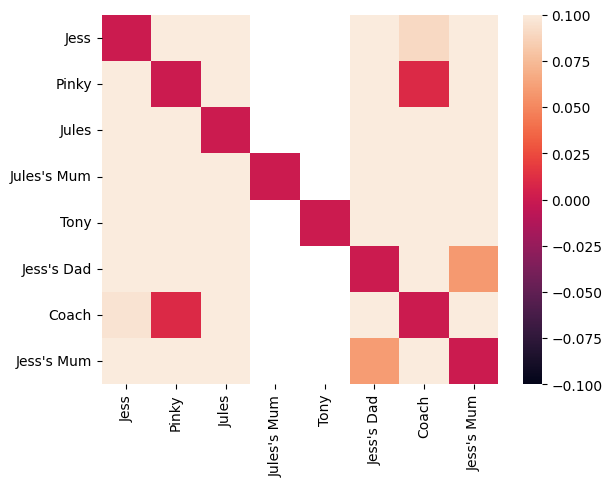

In [96]:
fig = plt.figure()
div = pd.DataFrame(
    M,
    columns=list(character_graph.nodes()),
    index=list(character_graph.nodes()),
)
ax = sns.heatmap(div)
plt.show()

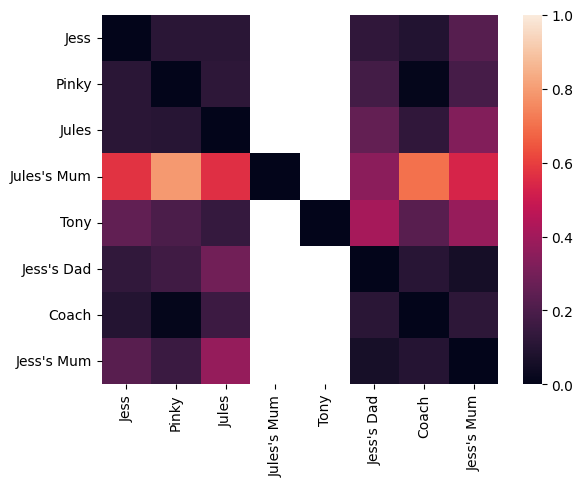

In [97]:
fig = plt.figure()
div = pd.DataFrame(
    M,
    columns=list(character_graph.nodes()),
    index=list(character_graph.nodes()),
)
ax = sns.heatmap(div, vmin=0, vmax=1)
plt.show()

Let us try and understand this plot: we see two clusters, one between Jules, Pinky and Jess, and the rest seperated. This makes sense! They all do use similar language in the movie: the Coach, Joe, and Jesse's Mum also speak quite similarly, which doesn't make a 100% sense, but they do talk about Jess a lot, so maybe that's the reason?

## Conclusions and Ways Forward

Phew - there was a lot going on there! We explored a variety of concepts, from networks, to topic models, to measuring similarities between topic models. These methods serve as the base for a variety of more complex analysis, and hopefully have served as a way to illustrate the kinds of tools Computational Social Scientists use throughout the analysis. A huge part of the notebook was also cleaning and organising data into different structures so that we can analyse them: this is a very important part of Computational Social Science, and indeed any data analysis exercise.

While the movie we chose to analyse may not have thrown us any very surprusing results, it did help in providing us some useful summarising ideas about the movie which we understood only by looking at the text of the script. While Social Scientists may not sit around analysing movie texts, if the process is operationalised to a large number of movies, it may be useful to have some of the metrics we learned in the tutorial today. Different social scientists use different parts of the tools we explored today to carry out their analysis.

If you wish to carry out your own academic research and analysis, focus on your research question and what kind of data might be helpful in answering the question. Then, explore the exisiting literature on the question, and think of a computational technique might help in add to the literature in a useful way. Outside of academia, these methods can still be used for a variety of business and personal needs.

Happy researching and problem solving - and feel free to reach out to me for any clarifications, advice, or suggestions/errata!